## Imports

In [34]:
import os, sys

In [36]:
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


In [ ]:
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [ ]:
# Install only once.
# !pip install --target=$nb_path pybullet envs
# !pip install --target=$nb_path glfw
# !pip install --target=$nb_path mujoco
# !pip install --target=$nb_path mujoco_py

In [ ]:
# !apt-get install --target=$nb_path x11-utils > /dev/null 2>&1
# !pip install --target=$nb_path pyglet > /dev/null 2>&1
# !apt-get install --target=$nb_path -y xvfb python-opengl > /dev/null 2>&1
# !pip install --target=$nb_path gym pyvirtualdisplay > /dev/null 2>&1

In [37]:
!sudo apt-get install xvfb
# !pip install --target=$nb_path xvfbwrapper

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
#### !pip install --target=$nb_path -U pybullet

In [38]:
import pybullet as p

p.connect(p.DIRECT)

3

In [ ]:
# !pip install --target=$nb_path numpngw

## Models

### Utilis

In [39]:
import torch as ch
from torch.distributions.categorical import Categorical
import numpy as np
'''
Common functions/utilities implemented in PyTorch
Sorted into categories:
- General functions
- Actor-critic helpers
- Policy gradient (PPO/TRPO) helpers
- Normalization helpers
- Neural network helpers
- Initialization helpers
'''

########################
### GENERAL UTILITY FUNCTIONS:
# Parameters, unroll, cu_tensorize, cpu_tensorize, shape_equal_cmp,
# shape_equal, scat, determinant, safe_op_or_neg_one
########################

CKPTS_TABLE = 'checkpoints'


class Parameters():
    '''
    Parameters class, just a nice way of accessing a dictionary
    > ps = Parameters({"a": 1, "b": 3})
    > ps.A # returns 1
    > ps.B # returns 3
    '''
    def __init__(self, params):
        self.params = params

    def __getattr__(self, x):
        return self.params[x.lower()]

def unroll(*tensors):
    '''
    Utility function unrolling a list of tensors
    Inputs:
    - tensors; all arguments should be tensors (at least 2D))))
    Returns:
    - The same tensors but with the first two dimensions flattened
    '''
    rets = []
    for t in tensors:
        assert len(t.shape) >= 2
        new_shape = [t.shape[0]*t.shape[1]] + list(t.shape[2:])
        rets.append(t.contiguous().view(new_shape))
    return rets

def cu_tensorize(t):
    '''
    Utility function for turning arrays into cuda tensors
    Inputs:
    - t, list
    Returns:
    - Tensor version of t
    '''
    return ch.tensor(t).float().cuda()

def cpu_tensorize(t):
    '''
    Utility function for turning arrays into cpu tensors
    Inputs:
    - t, list
    Returns:
    - Tensor version of t
    '''
    return ch.tensor(t).float()

def gpu_mapper():
    return ch.device('cuda:0') if not cpu else ch.device('cpu')

def shape_equal_cmp(*args):
    '''
    Checks that the shapes of the passed arguments are equal
    Inputs:
    - All arguments should be tensors
    Returns:
    - True if all arguments have the same shape, else ValueError
    '''
    for i in range(len(args)-1):
        if args[i].shape != args[i+1].shape:
            s = "\n".join([str(x.shape) for x in args])
            raise ValueError("Expected equal shapes. Got:\n%s" % s)
    return True

def shape_equal(a, *args):
    '''
    Checks that a group of tensors has a required shape
    Inputs:
    - a, required shape for all the tensors
    - Rest of the arguments are tensors
    Returns:
    - True if all tensors are of shape a, otherwise ValueError
    '''
    for arg in args:
        if list(arg.shape) != list(a):
            if len(arg.shape) != len(a):
                raise ValueError("Expected shape: %s, Got shape %s" \
                                    % (str(a), str(arg.shape)))
            for i in range(len(arg.shape)):
                if a[i] == -1 or a[i] == arg.shape[i]:
                    continue
                raise ValueError("Expected shape: %s, Got shape %s" \
                                    % (str(a), str(arg.shape)))
    return shape_equal_cmp(*args)

def scat(a, b, axis):
    '''
    Set-or-Cat (scat)
    Circumventing a PyTorch bug that auto-squeezes empty tensors.
    Inputs:
    a - A torch tensor, or None
    b - A torch tensor, can not be None
    axis - Axis to concat with
    Returns:
    - b if a is None, otherwise b concatted to a
    '''
    if a is None:
        return b
    return ch.cat((a, b), axis)

def determinant(mat):
    '''
    Returns the determinant of a diagonal matrix
    Inputs:
    - mat, a diagonal matrix
    Returns:
    - The determinant of mat, aka product of the diagonal
    '''
    return ch.exp(ch.log(mat).sum())

def safe_op_or_neg_one(maybe_empty, op):
    '''
    Performs an operation on a tensor which may be empty.
    Returns -1 if the tensor is empty, and returns the result
    of the op otherwise.
    Inputs:
    - maybe_empty, tensor which may be empty
    - op, an operation (tensor) -> (object) to perform
    Returns:
    - -1 if tensor is empty otherwise op(maybe_empty)
    '''
    if maybe_empty.nelement() == 0:
        return -1.
    else:
        return op(maybe_empty)

########################
### ACTOR-CRITIC HELPERS:
# discount_path, get_path_indices, select_prob_dists
########################

# Can be used to convert rewards into discounted returns:
# ret[i] = sum of t = i to T of gamma^(t-i) * rew[t]
def discount_path(path, h):
    '''
    Given a "path" of items x_1, x_2, ... x_n, return the discounted
    path, i.e.
    X_1 = x_1 + h*x_2 + h^2 x_3 + h^3 x_4
    X_2 = x_2 + h*x_3 + h^2 x_4 + h^3 x_5
    etc.
    Can do (more efficiently?) w SciPy. Python here for readability
    Inputs:
    - path, list/tensor of floats
    - h, discount rate
    Outputs:
    - Discounted path, as above
    '''
    curr = 0
    rets = []
    for i in range(len(path)):
        curr = curr*h + path[-1-i]
        rets.append(curr)
    rets =  ch.stack(list(reversed(rets)), 0)
    return rets

def get_path_indices(not_dones):
    """
    Returns list of tuples of the form:
        (agent index, time index start, time index end + 1)
    For each path seen in the not_dones array of shape (# agents, # time steps)
    E.g. if we have an not_dones of composition:
    tensor([[1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 1, 1, 0, 1, 1, 0, 1]], dtype=torch.uint8)
    Then we would return:
    [(0, 0, 3), (0, 3, 10), (1, 0, 3), (1, 3, 5), (1, 5, 9), (1, 9, 10)]
    """
    indices = []
    num_timesteps = not_dones.shape[1]
    for actor in range(not_dones.shape[0]):
        last_index = 0
        for i in range(num_timesteps):
            if not_dones[actor, i] == 0.:
                indices.append((actor, last_index, i + 1))
                last_index = i + 1
        if last_index != num_timesteps:
            indices.append((actor, last_index, num_timesteps))
    return indices

def select_prob_dists(pds, selected=None, detach=True):
    '''
    Given a tensor/tuple probability distributions, and
    some indices, select a subset of the distributions
    `pds`s according to the indices `selected`.
    Inputs:
    - pds: list of propo
    '''
    if type(pds) is tuple:
        if selected is not None:
            tup = (pds[0][selected], pds[1])
        else:
            tup = pds
        return tuple(x.detach() if detach else x for x in tup)
    out = pds[selected] if selected is not None else pds
    return out.detach() if detach else out


########################
### POLICY GRADIENT HELPERS:
# vjp, jvp, cg_solve, backtracking_line_search
########################

def vjp(f_x, theta, v, create=True):
    '''
    Vector-jacobian product
    Calculates v^TJ, or J^T v, using standard backprop
    Input:
    - f_x, function of which we want the Jacobian
    - theta, variable with respect to which we want Jacobian
    - v, vector that we want multiplied by the Jacobian
    Returns:
    - J^T @ v, without using n^2 space
    '''
    grad_list = ch.autograd.grad(f_x, theta, v, retain_graph=True, create_graph=create)
    return ch.nn.utils.parameters_to_vector(grad_list)

def jvp(f_x, theta, v):
    '''
    Jacobian-vector product
    Calculate the Jacobian-vector product, see
    https://j-towns.github.io/2017/06/12/A-new-trick.html for math
    Input:
    - f_x, function of which we want the Jacobian
    - theta, variable with respect to which we want Jacobian
    - v, vector that we want multiplied by the Jacobian
    Returns:
    - J @ v, without using n^2 space
    '''
    w = ch.ones_like(f_x, requires_grad=True)
    JTw = vjp(f_x, theta, w)
    return vjp(JTw, w, v)

def cg_solve(fvp_func, b, nsteps):
    '''
    Conjugate Gradients Algorithm
    Solves Hx = b, where H is the Fisher matrix and b is known
    Input:
    - fvp_func, a callable function returning Fisher-vector product
    - b, the RHS of the above
    - nsteps, the number of steps on CG to take
    Returns:
    - An approximate solution x of Hx = b
    '''
    # Initialize the solution, residual, direction vectors
    x = ch.zeros(b.size())
    r = b.clone()
    p = b.clone()
    new_rnorm = ch.dot(r,r)
    for _ in range(nsteps):
        rnorm = new_rnorm
        fvp = fvp_func(p)
        alpha = rnorm / ch.dot(p, fvp)
        x += alpha * p
        r -= alpha * fvp
        new_rnorm = ch.dot(r, r)
        ratio = new_rnorm / rnorm
        p = r + ratio * p
    return x

def backtracking_line_search(f, x, expected_improve_rate,
                             num_tries=10, accept_ratio=.1):
    '''
    Backtracking Line Search
    Inputs:
    - f, function for improvement of the objective
    - x, biggest step to try (successively halved)
    - num_tries, number of times to try halving x before giving up
    - accept_ratio, how much of the expected improve rate we have to
    improve by
    '''
    # f gives improvement
    for i in range(num_tries):
        scaling = 2**(-i)
        scaled = x * scaling
        improve = f(scaled)
        expected_improve = expected_improve_rate * scaling
        if improve/expected_improve > accept_ratio and improve > 0:
            print("We good! %f" % (scaling,))
            return scaled
    return 0.

########################
### NORMALIZATION HELPERS:
# RunningStat, ZFilter, StateWithTime
########################

class RunningStat(object):
    '''
    Keeps track of first and second moments (mean and variance)
    of a streaming time series.
     Taken from https://github.com/joschu/modular_rl
     Math in http://www.johndcook.com/blog/standard_deviation/
    '''
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)
    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)
    @property
    def n(self):
        return self._n
    @property
    def mean(self):
        return self._M
    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)
    @property
    def std(self):
        return np.sqrt(self.var)
    @property
    def shape(self):
        return self._M.shape

class Identity:
    '''
    A convenience class which simply implements __call__
    as the identity function
    '''
    def __call__(self, x, *args, **kwargs):
        return x

    def reset(self):
        pass

class RewardFilter:
    """
    Incorrect reward normalization [copied from OAI code]
    update return
    divide reward by std(return) without subtracting and adding back mean
    """
    def __init__(self, prev_filter, shape, gamma, clip=None):
        assert shape is not None
        self.gamma = gamma
        self.prev_filter = prev_filter
        self.rs = RunningStat(shape)
        self.ret = np.zeros(shape)
        self.clip = clip

    def __call__(self, x, **kwargs):
        x = self.prev_filter(x, **kwargs)
        self.ret = self.ret * self.gamma + x
        self.rs.push(self.ret)
        x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def reset(self):
        self.ret = np.zeros_like(self.ret)
        self.prev_filter.reset()

class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """
    def __init__(self, prev_filter, shape, center=True, scale=True, clip=None):
        assert shape is not None
        self.center = center
        self.scale = scale
        self.clip = clip
        self.rs = RunningStat(shape)
        self.prev_filter = prev_filter

    def __call__(self, x, **kwargs):
        x = self.prev_filter(x, **kwargs)
        self.rs.push(x)
        if self.center:
            x = x - self.rs.mean
        if self.scale:
            if self.center:
                x = x / (self.rs.std + 1e-8)
            else:
                diff = x - self.rs.mean
                diff = diff/(self.rs.std + 1e-8)
                x = diff + self.rs.mean
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def reset(self):
        self.prev_filter.reset()

class StateWithTime:
    '''
    Keeps track of the time t in an environment, and
    adds t/T as a dimension to the state, where T is the
    time horizon, given at initialization.
    '''
    def __init__(self, prev_filter, horizon):
        self.counter = 0
        self.horizon = horizon
        self.prev_filter = prev_filter

    def __call__(self, x, reset=False, count=True, **kwargs):
        x = self.prev_filter(x, **kwargs)
        self.counter += 1 if count else 0
        self.counter = 0 if reset else self.counter
        return np.array(list(x) + [self.counter/self.horizon,])

    def reset(self):
        self.prev_filter.reset()

# TODO: redo this in a not fucked way (ie using python language features)
class Trajectories:
    def __init__(self, states=None, rewards=None, returns=None, not_dones=None,
                 actions=None, action_log_probs=None, advantages=None,
                 unrolled=False, values=None):

        self.states = states
        self.rewards = rewards
        self.returns = returns
        self.values = values
        self.not_dones = not_dones
        self.actions = actions
        self.action_log_probs = action_log_probs
        self.advantages = advantages
        self.unrolled = unrolled

        # this is disgusting and we should fix it
        if states is not None:
            num_saps = states.shape[0]
            assert states is None or states.shape[0] == num_saps
            assert rewards is None or rewards.shape[0] == num_saps
            assert returns is None or returns.shape[0] == num_saps
            assert values is None or values.shape[0] == num_saps
            assert not_dones is None or not_dones.shape[0] == num_saps
            assert actions is None or actions.shape[0] == num_saps
            assert action_log_probs is None or action_log_probs.shape[0] == num_saps
            assert advantages is None or advantages.shape[0] == num_saps

            self.size = num_saps

    def unroll(self):
        assert not self.unrolled
        return self.tensor_op(unroll, should_wrap=False)

    def tensor_op(self, lam, should_wrap=True):
        if should_wrap:
            def op(*args):
                return [lam(v) for v in args]
        else:
            op = lam

        tt = op(self.states, self.rewards, self.returns, self.not_dones)
        tt2 = op(self.actions, self.action_log_probs, self.advantages)
        values, = op(self.values)

        ts = Trajectories(states=tt[0], rewards=tt[1], returns=tt[2],
                          not_dones=tt[3], actions=tt2[0],
                          action_log_probs=tt2[1], advantages=tt2[2],
                          values=values, unrolled=True)

        return ts

########################
### NEURAL NETWORK HELPERS:
# orthogonal_init
########################

def orthogonal_init(tensor, gain=1):
    '''
    Fills the input `Tensor` using the orthogonal initialization scheme from OpenAI
    Args:
        tensor: an n-dimensional `torch.Tensor`, where :math:`n \geq 2`
        gain: optional scaling factor
    Examples:
        >>> w = torch.empty(3, 5)
        >>> orthogonal_init(w)
    '''
    if tensor.ndimension() < 2:
        raise ValueError("Only tensors with 2 or more dimensions are supported")

    rows = tensor.size(0)
    cols = tensor[0].numel()
    flattened = tensor.new(rows, cols).normal_(0, 1)

    if rows < cols:
        flattened.t_()

    # Compute the qr factorization
    u, s, v = ch.svd(flattened, some=True)
    if rows < cols:
        u.t_()
    q = u if tuple(u.shape) == (rows, cols) else v
    with ch.no_grad():
        tensor.view_as(q).copy_(q)
        tensor.mul_(gain)
    return tensor

### Hyper Network

#### Normal

In [40]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResBlock(nn.Module):

    def __init__(self, in_size, out_size):
        super(ResBlock, self).__init__()
        self.fc = nn.Sequential(
                            nn.ReLU(),
                            nn.Linear(in_size, out_size),
                            nn.ReLU(),
                            nn.Linear(out_size, out_size),
                            )

    def forward(self, x):
        h = self.fc(x)
        return x + h

class Head(nn.Module):

    def __init__(self, latent_dim, output_dim_in, output_dim_out, sttdev):
        super(Head, self).__init__()

        h_layer = 1024
        self.output_dim_in = output_dim_in
        self.output_dim_out = output_dim_out

        self.W1 = nn.Linear(h_layer, output_dim_in * output_dim_out)
        self.b1 = nn.Linear(h_layer, output_dim_out)
        self.s1 = nn.Linear(h_layer, output_dim_out)

        self.init_layers(sttdev)

    def forward(self, x):

        # weights, bias and scale for dynamic layer
        w = self.W1(x).view(-1, self.output_dim_out, self.output_dim_in)
        b = self.b1(x).view(-1, self.output_dim_out, 1)
        s = 1. + self.s1(x).view(-1, self.output_dim_out, 1)

        return w, b, s

    def init_layers(self, stddev):

        torch.nn.init.uniform_(self.W1.weight, -stddev, stddev)
        torch.nn.init.uniform_(self.b1.weight, -stddev, stddev)
        torch.nn.init.uniform_(self.s1.weight, -stddev, stddev)

        torch.nn.init.zeros_(self.W1.bias)
        torch.nn.init.zeros_(self.b1.bias)
        torch.nn.init.zeros_(self.s1.bias)


class Meta_Embadding(nn.Module):

    def __init__(self, meta_dim, z_dim):

        super(Meta_Embadding, self).__init__()

        self.z_dim = z_dim

        self.hyper = nn.Sequential(

			nn.Linear(meta_dim, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),

            nn.Linear(256, 512),
            ResBlock(512, 512),
            ResBlock(512, 512),

            nn.Linear(512, 1024),
            ResBlock(1024, 1024),
            ResBlock(1024, 1024),

		)

        self.init_layers()

    def forward(self, meta_v):
        z = self.hyper(meta_v).view(-1, self.z_dim)
        return z

    def init_layers(self):

        for module in self.hyper.modules():
            if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Linear)):
                fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out(module.weight)
                bound = 1. / math.sqrt(2 * fan_in)
                torch.nn.init.uniform_(module.weight, -bound, bound)

class Hyper_QNetwork(nn.Module):
    # Hyper net create weights with respect to the state and estimates function Q_s(a)
    def __init__(self,meta_v_dim, base_v_dim):
        super(Hyper_QNetwork, self).__init__()

        dynamic_layer = 256
        z_dim = 1024

        self.hyper = Meta_Embadding(meta_v_dim, z_dim)

        # Q function net
        self.layer1 = Head(z_dim, base_v_dim, dynamic_layer, sttdev=0.05)
        self.last_layer = Head(z_dim, dynamic_layer, 1,  sttdev=0.008)

    def forward(self, meta_v, base_v, debug=None):
        # produce dynmaic weights
        z = self.hyper(meta_v)
        # print("z:", z.shape)
        w1 ,b1 ,s1 = self.layer1(z)
        w2, b2, s2 = self.last_layer(z)

        # dynamic network pass
        # print(w1.shape, base_v.shape, base_v.unsqueeze(2).shape)
        out = F.relu(torch.bmm(w1, base_v.unsqueeze(2)) * s1 + b1)
        out = torch.bmm(w2, out) * s2 + b2

        return out.view(-1, 1)

#### Hyperfan

In [41]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(ResBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(in_size, out_size),
            nn.ReLU(),
            nn.Linear(out_size, out_size),
        )

    def forward(self, x):
        h = self.fc(x)
        return x + h

class Head(nn.Module):
    def __init__(self, latent_dim, output_dim_in, output_dim_out, sttdev):
        super(Head, self).__init__()

        h_layer = 1024
        self.output_dim_in = output_dim_in
        self.output_dim_out = output_dim_out

        self.W1 = nn.Linear(h_layer, output_dim_in * output_dim_out)
        self.b1 = nn.Linear(h_layer, output_dim_out)
        self.s1 = nn.Linear(h_layer, output_dim_out)

        self.init_layers(sttdev)

    def forward(self, x):
        # weights, bias and scale for dynamic layer
        w = self.W1(x).view(-1, self.output_dim_out, self.output_dim_in)
        b = self.b1(x).view(-1, self.output_dim_out, 1)
        s = 1.0 + self.s1(x).view(-1, self.output_dim_out, 1)

        return w, b, s

    def init_layers(self, stddev):
        # Apply weight initialization
        self.W1.weight.data = hyperfaninWi_init(0)(self.W1.weight.data)
        self.W1.bias.data = torch.zeros_like(self.W1.bias.data)

        self.b1.weight.data = hyperfanoutWi_init(0)(self.b1.weight.data)
        self.b1.bias.data = torch.zeros_like(self.b1.bias.data)

        self.s1.weight.data = hyperfanoutWi_init(0)(self.s1.weight.data)
        self.s1.bias.data = torch.zeros_like(self.s1.bias.data)

class Meta_Embadding(nn.Module):
    def __init__(self, meta_dim, z_dim):
        super(Meta_Embadding, self).__init__()

        self.z_dim = z_dim

        self.hyper = nn.Sequential(
            nn.Linear(meta_dim, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            nn.Linear(256, 512),
            ResBlock(512, 512),
            ResBlock(512, 512),
            nn.Linear(512, 1024),
            ResBlock(1024, 1024),
            ResBlock(1024, 1024),
        )

        self.init_layers()

    def forward(self, meta_v):
        z = self.hyper(meta_v).view(-1, self.z_dim)
        return z

    def init_layers(self):
        for module in self.hyper.modules():
            if isinstance(module, nn.Linear):
                module.weight.data = hyperfaninWi_init(0)(module.weight.data)
                module.bias.data = torch.zeros_like(module.bias.data)

class Hyper_QNetwork(nn.Module):
    def __init__(self, meta_v_dim, base_v_dim):
        super(Hyper_QNetwork, self).__init__()

        dynamic_layer = 256
        z_dim = 1024

        self.hyper = Meta_Embadding(meta_v_dim, z_dim)

        # Q function net
        self.layer1 = Head(z_dim, base_v_dim, dynamic_layer, sttdev=0.05)
        self.last_layer = Head(z_dim, dynamic_layer, 1, sttdev=0.008)

    def forward(self, meta_v, base_v, debug=None):
        # produce dynamic weights
        z = self.hyper(meta_v)
        w1, b1, s1 = self.layer1(z)
        w2, b2, s2 = self.last_layer(z)

        # dynamic network pass
        out = F.relu(torch.bmm(w1, base_v.unsqueeze(2)) * s1 + b1)
        out = torch.bmm(w2, out) * s2 + b2

        return out.view(-1, 1)

# variables for hyperfan initialization
input_size = 3
n_classes = 10
hyperfanin = [input_size] * input_size + [96] * 96 * 4 + [
    192
] * (192 * 8 + 2 * n_classes)

hyperfanout = [96] * (input_size + 96 * 2) + [192] * (192 * 9) + [
    n_classes
] * 2 * n_classes

receptive = lambda i: 9 if i < input_size + 192 * 8 else 1


def hyperfaninWi_init(i):
    def hyperfanin_init(Wi):
        fan_out, fan_in = Wi.size(0), Wi.size(1)
        bound = math.sqrt(3 * 2 / (fan_in * hyperfanin[i]) / receptive(i))
        Wi.uniform_(-bound, bound)
        return Wi

    return hyperfanin_init


def hyperfanoutWi_init(i):
    def hyperfanout_init(Wi):
        fan_out, fan_in = Wi.size(0), Wi.size(1)
        bound = math.sqrt(3 * 2 / (fan_in * hyperfanout[i]) / receptive(i))
        Wi.uniform_(-bound, bound)
        return Wi

    return hyperfanout_init


def fanin_uniform(W):
    fan_out, fan_in = W.size(0), W.size(1)
    bound = math.sqrt(3 * 2 / fan_in)
    W.uniform_(-bound, bound)
    return W


def embed_uniform(e):
    bound = math.sqrt(3)
    e.uniform_(-bound, bound)
    return e

#### With Attention

In [42]:
# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class ResBlock(nn.Module):

#     def __init__(self, in_size, out_size):
#         super(ResBlock, self).__init__()
#         self.fc = nn.Sequential(
#                             nn.ReLU(),
#                             nn.Linear(in_size, out_size),
#                             nn.ReLU(),
#                             nn.Linear(out_size, out_size),
#                             )

#     def forward(self, x):
#         h = self.fc(x)
#         return x + h

# class Head(nn.Module):

#     def __init__(self, latent_dim, output_dim_in, output_dim_out, sttdev):
#         super(Head, self).__init__()

#         h_layer = 1024
#         self.output_dim_in = output_dim_in
#         self.output_dim_out = output_dim_out

#         self.W1 = nn.Linear(h_layer, output_dim_in * output_dim_out)
#         self.b1 = nn.Linear(h_layer, output_dim_out)
#         self.s1 = nn.Linear(h_layer, output_dim_out)

#         self.init_layers(sttdev)

#     def forward(self, x):

#         # weights, bias, and scale for the dynamic layer
#         # print("W1:", self.W1(x))
#         # print("W1:", self.W1(x).view(-1, self.output_dim_out, self.output_dim_in))
#         w = self.W1(x).view(-1, self.output_dim_out, self.output_dim_in)
#         b = self.b1(x).view(-1, self.output_dim_out, 1)
#         s = 1. + self.s1(x).view(-1, self.output_dim_out, 1)
#         # print("w: ", w.shape)
#         # w:  torch.Size([2048, 256, 3])
#         # w:  torch.Size([2048, 1, 256])
#         return w, b, s

#     def init_layers(self, stddev):

#         torch.nn.init.uniform_(self.W1.weight, -stddev, stddev)
#         torch.nn.init.uniform_(self.b1.weight, -stddev, stddev)
#         torch.nn.init.uniform_(self.s1.weight, -stddev, stddev)

#         torch.nn.init.zeros_(self.W1.bias)
#         torch.nn.init.zeros_(self.b1.bias)
#         torch.nn.init.zeros_(self.s1.bias)

# # class Head(nn.Module):
# #     def __init__(self, latent_dim, output_dim_in, output_dim_out, sttdev):
# #         super(Head, self).__init__()

# #         h_layer = 1024
# #         self.output_dim_in = output_dim_in
# #         self.output_dim_out = output_dim_out

# #         self.W1 = nn.Linear(h_layer, output_dim_in * output_dim_out)
# #         self.b1 = nn.Linear(h_layer, output_dim_out)
# #         self.s1 = nn.Linear(h_layer, output_dim_out)

# #         self.init_layers(sttdev)
##          if hasattr(self, 'last_layer') and x.shape[1] == self.last_layer:
# #             w = F.normalize(w, p=2, dim=-1) * math.sqrt(2)

# #     def forward(self, x):
# #         # weights, bias, and scale for the dynamic layer
# #         w = self.W1(x).view(-1, self.output_dim_out, self.output_dim_in)
# #         b = self.b1(x).view(-1, self.output_dim_out, 1)
# #         s = 1. + self.s1(x).view(-1, self.output_dim_out, 1)

# #         # Applying normc initialization to the last layer weights
# #         if hasattr(self, 'last_layer') and x.shape[1] == self.last_layer:
# #             w = F.normalize(w, p=2, dim=-1) * math.sqrt(2)

#         # return w, b, s

#     def init_layers(self, stddev):
#         torch.nn.init.uniform_(self.W1.weight, -stddev, stddev)
#         torch.nn.init.uniform_(self.b1.weight, -stddev, stddev)
#         torch.nn.init.uniform_(self.s1.weight, -stddev, stddev)

#         torch.nn.init.zeros_(self.W1.bias)
#         torch.nn.init.zeros_(self.b1.bias)
#         torch.nn.init.zeros_(self.s1.bias)

# class MultiHeadAttention(nn.Module):

#     def __init__(self, num_heads, model_dim):
#         super(MultiHeadAttention, self).__init__()
#         self.num_heads = num_heads
#         self.model_dim = model_dim
#         assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads."
#         self.head_dim = model_dim // num_heads

#         self.linear_q = nn.Linear(model_dim, model_dim)
#         self.linear_k = nn.Linear(model_dim, model_dim)
#         self.linear_v = nn.Linear(model_dim, model_dim)

#     def forward(self, q, k, v, mask=None):
#         batch_size, seq_len, _ = q.size()

#         # Linear projections for queries, keys, and values
#         Q = self.linear_q(q).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
#         K = self.linear_k(k).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
#         V = self.linear_v(v).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

#         # Calculate dot products
#         dot_product = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

#         if mask is not None:
#             dot_product = dot_product.masked_fill(mask == 0, float("-inf"))

#         attention_weights = F.softmax(dot_product, dim=-1)
#         output = torch.matmul(attention_weights, V)

#         # Reshape and concatenate
#         output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.model_dim)

#         return output

# class Meta_Embadding(nn.Module):

#     def __init__(self, meta_dim, z_dim, num_attention_heads):
#         super(Meta_Embadding, self).__init__()

#         self.z_dim = z_dim
#         self.num_attention_heads = num_attention_heads

#         self.hyper = nn.Sequential(
#             nn.Linear(meta_dim, 256),
#             ResBlock(256, 256),
#             ResBlock(256, 256),
#             nn.Linear(256, 512),
#             ResBlock(512, 512),
#             ResBlock(512, 512),
#             nn.Linear(512, 1024),
#             ResBlock(1024, 1024),
#             ResBlock(1024, 1024)
#         )

#         self.attention = MultiHeadAttention(num_attention_heads, 1024)

#         self.init_layers()

#     def forward(self, meta_v):
#         z = self.hyper(meta_v).view(-1, self.z_dim)
#         z = z.unsqueeze(1).repeat(1, self.num_attention_heads, 1)
#         z = self.attention(z, z, z)
#         return z

#     def init_layers(self):
#         for module in self.hyper.modules():
#             if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Linear)):
#                 fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out(module.weight)
#                 bound = 1. / math.sqrt(2 * fan_in)
#                 torch.nn.init.uniform_(module.weight, -bound, bound)

# class Hyper_QNetwork(nn.Module):

#     def __init__(self, meta_v_dim, base_v_dim, num_attention_heads):
#         super(Hyper_QNetwork, self).__init__()

#         dynamic_layer = 256
#         z_dim = 1024

#         self.num_attention_heads = num_attention_heads

#         self.hyper = Meta_Embadding(meta_v_dim, z_dim, num_attention_heads)

#         # Q function net
#         self.layer1 = Head(z_dim, base_v_dim, dynamic_layer, sttdev=0.05)
#         self.last_layer = Head(z_dim, dynamic_layer, 1, sttdev=0.008)

#     def forward(self, meta_v, base_v, debug=None):
#         # produce dynamic weights
#         z = self.hyper(meta_v)
#         # print("z:", z.shape)
#         # z: torch.Size([256, 8, 1024])
#         # without attention z: torch.Size([256, 1024])
#         z = z.squeeze(1)
#         # print("z:", z.shape)
#         w1, b1, s1 = self.layer1(z)
#         w2, b2, s2 = self.last_layer(z)

#         # dynamic network pass
#         # print(w1.shape, base_v.shape, base_v.unsqueeze(2).shape)
#         # torch.Size([2048, 256, 3]) torch.Size([256, 3]) torch.Size([256, 3, 1])
#         # Otherwise torch.Size([256, 256, 3]) torch.Size([256, 3]) torch.Size([256, 3, 1])
#         out = F.relu(torch.bmm(w1, base_v.unsqueeze(2)) * s1 + b1)
#         # out = F.relu(torch.bmm(w1, base_v.transpose(1, 2)) * s1 + b1)
#         # out = F.relu(torch.bmm(w1, base_v.unsqueeze(2)).squeeze(2) * s1 + b1)


#         out = torch.bmm(w2, out) * s2 + b2

#         return out.view(-1, 1)

### Hyper-Q-Network

In [43]:
import torch.nn as nn

class Hyper_Critic(nn.Module):
    # Hyper net that create weights from the state for a net that estimates function Q(S, A)
    def __init__(self, state_dim, action_dim, num_hidden=1):
        super(Hyper_Critic, self).__init__()
        meta_v_dim = state_dim
        base_v_dim = action_dim
        # meta_v_dim = action_dim
        # base_v_dim = state_dim
        self.q1 = Hyper_QNetwork(meta_v_dim, base_v_dim)
        self.q2 = Hyper_QNetwork(meta_v_dim, base_v_dim)
        # self.q1 = Hyper_QNetwork(meta_v_dim, base_v_dim, 1)
        # self.q2 = Hyper_QNetwork(meta_v_dim, base_v_dim, 1)

    def forward(self, state, action):
        q1 = self.q1(state, action)
        q2 = self.q2(state, action)
        return q1,q2

    def Q1(self, state, action):
        q1 = self.q1(state, action)
        return q1

### Helper

In [44]:
import gym
from collections import deque
import random
import numpy as np
import torch.nn as nn
from gym.wrappers import TimeLimit
import torch


# replay buffer
class ReplayMemory:
    def __init__(self,size):
        self.size = size
        self.memory = deque([],maxlen=size)

    def push(self, x):
        self.memory.append(x)

    def sample(self, batch_size):
        batch = random.sample(self.memory,batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def get_len(self):
        return len(self.memory)

# weight update methods
def copy_params(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0)

# for
class TimeFeatureWrapper(gym.Wrapper):
    """
    Add remaining time to observation space for fixed length episodes.
    See https://arxiv.org/abs/1712.00378 and https://github.com/aravindr93/mjrl/issues/13.
    :param env: (gym.Env)
    :param max_steps: (int) Max number of steps of an episode
        if it is not wrapped in a TimeLimit object.
    :param test_mode: (bool) In test mode, the time feature is constant,
        equal to zero. This allow to check that the agent did not overfit this feature,
        learning a deterministic pre-defined sequence of actions.
    """
    def __init__(self, env, max_steps=1000, test_mode=False):
        assert isinstance(env.observation_space, gym.spaces.Box)
        # Add a time feature to the observation
        low, high = env.observation_space.low, env.observation_space.high
        low, high= np.concatenate((low, [0])), np.concatenate((high, [1.]))
        env.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

        super(TimeFeatureWrapper, self).__init__(env)

        if isinstance(env, TimeLimit):
            self._max_steps = env._max_episode_steps
        else:
            self._max_steps = max_steps
        self._current_step = 0
        self._test_mode = test_mode

    def reset(self):
        self._current_step = 0
        return self._get_obs(self.env.reset())

    def step(self, action):
        self._current_step += 1
        obs, reward, done, info = self.env.step(action)
        return self._get_obs(obs), reward, done, info

    def _get_obs(self, obs):
        """
        Concatenate the time feature to the current observation.
        :param obs: (np.ndarray)
        :return: (np.ndarray)
        """
        # Remaining time is more general
        time_feature = 1 - (self._current_step / self._max_steps)
        if self._test_mode:
            time_feature = 1.0
        # Optionnaly: concatenate [time_feature, time_feature ** 2]
        return np.concatenate((obs, [time_feature]))

#### Prioritised Experience Replay

In [45]:
class SumTree:
    def __init__(self, size):
        self.nodes = [0] * (2 * size - 1)
        self.data = [None] * size

        self.size = size
        self.count = 0
        self.real_size = 0

    @property
    def total(self):
        return self.nodes[0]

    def update(self, data_idx, value):
        idx = data_idx + self.size - 1  # child index in tree array
        change = value - self.nodes[idx]

        self.nodes[idx] = value

        parent = (idx - 1) // 2
        while parent >= 0:
            self.nodes[parent] += change
            parent = (parent - 1) // 2

    def add(self, value, data):
        self.data[self.count] = data
        self.update(self.count, value)

        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)

    def get(self, cumsum):
        assert cumsum <= self.total

        idx = 0
        while 2 * idx + 1 < len(self.nodes):
            left, right = 2*idx + 1, 2*idx + 2

            if cumsum <= self.nodes[left]:
                idx = left
            else:
                idx = right
                cumsum = cumsum - self.nodes[left]

        data_idx = idx - self.size + 1

        if self.data[data_idx] is None:
          last_value = max(filter(None, self.data), default=0)
          self.data[data_idx] = last_value - 1

        return data_idx, self.nodes[idx], self.data[data_idx]

    def __repr__(self):
        return f"SumTree(nodes={self.nodes.__repr__()}, data={self.data.__repr__()})"

In [46]:
class PrioritizedReplayBuffer:
    def __init__(self, state_size, action_size, buffer_size, eps=1e-2, alpha=0.7, beta=0.4):
        self.tree = SumTree(size=buffer_size)

        # PER params
        self.eps = eps  # minimal priority, prevents zero probabilities
        self.alpha = alpha  # determines how much prioritization is used, α = 0 corresponding to the uniform case
        self.beta = beta  # determines the amount of importance-sampling correction, b = 1 fully compensate for the non-uniform probabilities
        self.max_priority = eps  # priority for new samples, init as eps

        # transition: state, action, reward, next_state, done
        self.state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.action = torch.empty(buffer_size, action_size, dtype=torch.float)
        self.reward = torch.empty(buffer_size, dtype=torch.float)
        self.next_state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.done = torch.empty(buffer_size, dtype=torch.int)

        self.count = 0
        self.real_size = 0
        self.size = buffer_size

    def push(self, transition):
        state, action, reward, next_state, done = transition

        # store transition index with maximum priority in sum tree
        self.tree.add(self.max_priority, self.count)

        # store transition in the buffer
        self.state[self.count] = torch.as_tensor(state)
        self.action[self.count] = torch.as_tensor(action)
        self.reward[self.count] = torch.as_tensor(reward)
        self.next_state[self.count] = torch.as_tensor(next_state)
        self.done[self.count] = torch.as_tensor(done)

        # update counters
        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)

    def sample(self, batch_size):
        assert self.real_size >= batch_size, "buffer contains less samples than batch size"

        sample_idxs, tree_idxs = [], []
        priorities = torch.empty(batch_size, 1, dtype=torch.float)

        # To sample a minibatch of size k, the range [0, p_total] is divided equally into k ranges.
        # Next, a value is uniformly sampled from each range. Finally the transitions that correspond
        # to each of these sampled values are retrieved from the tree. (Appendix B.2.1, Proportional prioritization)
        segment = self.tree.total / batch_size
        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)

            cumsum = random.uniform(a, b)
            # sample_idx is a sample index in buffer, needed further to sample actual transitions
            # tree_idx is a index of a sample in the tree, needed further to update priorities
            tree_idx, priority, sample_idx = self.tree.get(cumsum)

            priorities[i] = torch.tensor(priority)
            tree_idxs.append(tree_idx)
            sample_idxs.append(sample_idx)

        # if self.real_size > 2500:
        #     print("s_idxs:", type(sample_idxs))
        # Concretely, we define the probability of sampling transition i as P(i) = p_i^α / \sum_{k} p_k^α
        # where p_i > 0 is the priority of transition i. (Section 3.3)
        probs = priorities / self.tree.total
        # probs = probs + self.eps

        # if self.real_size > 2560:
        #   print("p:", probs)

        # The estimation of the expected value with stochastic updates relies on those updates corresponding
        # to the same distribution as its expectation. Prioritized replay introduces bias because it changes this
        # distribution in an uncontrolled fashion, and therefore changes the solution that the estimates will
        # converge to (even if the policy and state distribution are fixed). We can correct this bias by using
        # importance-sampling (IS) weights w_i = (1/N * 1/P(i))^β that fully compensates for the non-uniform
        # probabilities P(i) if β = 1. These weights can be folded into the Q-learning update by using w_i * δ_i
        # instead of δ_i (this is thus weighted IS, not ordinary IS, see e.g. Mahmood et al., 2014).
        # For stability reasons, we always normalize weights by 1/maxi wi so that they only scale the
        # update downwards (Section 3.4, first paragraph)
        weights = (self.real_size * probs) ** -self.beta
        # if self.real_size > 2500:
        #   print("w:", type(weights))

        # As mentioned in Section 3.4, whenever importance sampling is used, all weights w_i were scaled
        # so that max_i w_i = 1. We found that this worked better in practice as it kept all weights
        # within a reasonable range, avoiding the possibility of extremely large updates. (Appendix B.2.1, Proportional prioritization)
        weights = weights / weights.max()
        # if self.real_size > 2560:
        #   print("w:", type(weights))

        # batch = (
        #     self.state[sample_idxs].to(device()),
        #     self.action[sample_idxs].to(device()),
        #     self.reward[sample_idxs].to(device()),
        #     self.next_state[sample_idxs].to(device()),
        #     self.done[sample_idxs].to(device())
        # )
        # return batch, weights, tree_idxs

        if sample_idxs[-1] is None:
          print(sample_idxs)

        if torch.isnan(self.next_state[sample_idxs][-1]).any():
          print(self.next_state[sample_idxs][-1])

        # return self.state[sample_idxs].to(device), self.action[sample_idxs].to(device), self.reward[sample_idxs].to(device), self.next_state[sample_idxs].to(device), self.done[sample_idxs].to(device),  weights, tree_idxs
        return self.state[sample_idxs], self.action[sample_idxs], self.reward[sample_idxs], self.next_state[sample_idxs], self.done[sample_idxs],  weights, tree_idxs

    def update_priorities(self, data_idxs, priorities):
        if isinstance(priorities, torch.Tensor):
            priorities = priorities.detach().cpu().numpy()

        for data_idx, priority in zip(data_idxs, priorities):
            # The first variant we consider is the direct, proportional prioritization where p_i = |δ_i| + eps,
            # where eps is a small positive constant that prevents the edge-case of transitions not being
            # revisited once their error is zero. (Section 3.3)
            priority = (priority + self.eps) ** self.alpha

            self.tree.update(data_idx, priority)
            self.max_priority = max(self.max_priority, priority)

    def get_len(self):
        return self.real_size
        # return len(self.memory)

### Policy Network

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Normal

class PolicyNetwork(nn.Module):
    def __init__(self,s_dim,a_dim,h_dim,action_space,min_log,max_log,epsilon, device):
        super(PolicyNetwork,self).__init__()
        self.min_log = min_log
        self.max_log = max_log
        self.epsilon = epsilon

        self.linear1 = nn.Linear(s_dim,h_dim)
        self.linear2 = nn.Linear(h_dim,h_dim)

        self.linear3a = nn.Linear(h_dim,a_dim)
        self.linear3b = nn.Linear(h_dim,a_dim)

        # Apply weight initialisation to all linear layers
        self.apply(init_weights)

        # rescale actions
        if action_space is None:
            self.action_scale = torch.tensor(1.).to(device)
            self.action_bias = torch.tensor(0.).to(device)
        else:
            self.action_scale = torch.FloatTensor(
                (action_space.high - action_space.low) / 2.).to(device)
            self.action_bias = torch.FloatTensor(
                (action_space.high + action_space.low) / 2.).to(device)


    def forward(self,s):
        x = F.relu(self.linear1(s))
        x = F.relu(self.linear2(x))

        mean = self.linear3a(x)
        log_std = self.linear3b(x)

        # constrain log value in finite range to avoid NaN loss values
        log_std = torch.clamp(log_std, min=self.min_log, max=self.max_log)

        return mean, log_std

    def sample_action(self,s, deterministic=False):
        mean, log_std = self.forward(s)
        std = log_std.exp()

        if deterministic:
            return mean

        # calculate action using reparameterization trick and action scaling
        normal = Normal(mean, std)
        xi = normal.rsample()
        log_pi = normal.log_prob(xi).sum(axis=-1)
        log_pi -= (2*(np.log(2) - xi - F.softplus(-2*xi))).sum(axis=1)

        yi = torch.tanh(xi)
        a = self.action_scale * yi

        return a, log_pi, mean, log_std

### Q-Network

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# from helper import init_weights

class QNetwork(nn.Module):
    def __init__(self,s_dim,a_dim,h_dim):
        super(QNetwork,self).__init__()

        self.linear1 = nn.Linear(s_dim+a_dim,h_dim) ###
        self.linear2 = nn.Linear(h_dim,h_dim)
        self.linear3 = nn.Linear(h_dim,1)

        self.apply(init_weights)

    def forward(self,s,a):
        x = torch.cat((s,a),dim=1)###
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

# Res35
class Deep_Critic(nn.Module):
	def __init__(self,s_dim,a_dim,h_dim):
		super(Deep_Critic, self).__init__()
		h_size = 256
		n_blocks = 35

		self.q1 = nn.Sequential(nn.Linear(s_dim + a_dim, h_size),)
		for i in range(n_blocks):
			self.q1.add_module("block_{}".format(i), ResBlock(h_size, h_size))
		self.q1.add_module("relu_1", nn.ReLU())
		self.q1.add_module("fc",nn.Linear(h_size, 1))

	def forward(self, state, action):
		sa1 = torch.cat([state, action], 1)
		q1 = self.q1(sa1)
		return q1


class Critic(nn.Module):
    def __init__(self,s_dim,a_dim,h_dim):
        super(Critic,self).__init__()
        D2rl = False
        res35 = False
        feature_emb = False

        if D2rl:
            self.q1 = D2rl_Q(s_dim,a_dim,h_dim)
            self.q2 = D2rl_Q(s_dim,a_dim,h_dim)
        elif res35:
            self.q1 = Deep_Critic(s_dim,a_dim,h_dim)
            self.q2 = Deep_Critic(s_dim,a_dim,h_dim)
        elif feature_emb:
            self.q1 = Super_Critic(s_dim,a_dim,h_dim)
            self.q2 = Super_Critic(s_dim,a_dim,h_dim)
        else:
            self.q1 = QNetwork(s_dim,a_dim,h_dim)
            self.q2 = QNetwork(s_dim,a_dim,h_dim)


        self.apply(init_weights)

    def forward(self,s,a):
        q1 = self.q1(s,a)
        q2 = self.q2(s,a)
        return q1,q2

    def Q1(self, s, a):
        q1 = self.q1(s, a)
        return q1


class D2rl_Q(nn.Module):
	def __init__(self, state_dim, action_dim, h_size):
		super(D2rl_Q, self).__init__()

		in_dim = state_dim + action_dim + h_size
		self.l1_1 = nn.Linear(state_dim + action_dim, h_size)
		self.l1_2 = nn.Linear(in_dim, h_size)
		self.l1_3 = nn.Linear(in_dim, h_size)
		self.l1_4 = nn.Linear(in_dim, h_size)
		self.out1 = nn.Linear(h_size, 1)

	def forward(self, s,a):
		xu = torch.cat([s,a], dim=1)
		x1 = F.relu(self.l1_1(xu))
		x1 = torch.cat([x1, xu], dim=1)
		x1 = F.relu(self.l1_2(x1))
		x1 = torch.cat([x1, xu], dim=1)
		x1 = F.relu(self.l1_3(x1))
		x1 = torch.cat([x1, xu], dim=1)
		x1 = F.relu(self.l1_4(x1))
		x1 = self.out1(x1)
		return x1

# feature embedding
class Super_Critic(nn.Module):
	def __init__(self,s_dim,a_dim,h_dim):
		super(Super_Critic, self).__init__()
		print("super")
		h_size = 256
		# Q1 architecture
		self.q1_emb = nn.Sequential(
			Meta_Embadding(s_dim, 1024),
			nn.Linear(1024, 10)
		)
		self.q1 = nn.Sequential(
				nn.Linear(10 + a_dim, h_size),
				nn.ReLU(),
				nn.Linear(h_size, 1)
		)

		# Q2 architecture
		self.q2_emb = nn.Sequential(
			Meta_Embadding(s_dim, 1024),
			nn.Linear(1024, 10)
		)
		self.q2 = nn.Sequential(
				nn.Linear(10 + a_dim, h_size),
				nn.ReLU(),
				nn.Linear(h_size, 1)
		)

		self.apply(init_weights)

	def forward(self, state, action):
		z1 = self.q1_emb(state)
		z2 = self.q2_emb(state)
		sa1 = torch.cat([z1, action], 1)
		sa2 = torch.cat([z2, action], 1)
		q1 = self.q1(sa1)
		q2 = self.q2(sa2)
		return q1, q2

	def Q1(self, s, a):
		z1 = self.q1_emb(s)
		sa1 = torch.cat([z1, a], 1)
		q1 = self.q1(sa1)
		return q1

### Soft Actor Critic

In [49]:
class IncreaseDimNetwork(nn.Module):
    def __init__(self, shape):
        super(IncreaseDimNetwork, self).__init__()
        self.fc = nn.Linear(shape, 15)

    def forward(self, x):
        # x = self.fc(x)
        return x

In [50]:
import torch
import torch.optim as opt
import torch.nn.functional as F
import numpy as np

class SoftActorCritic(object):
    def __init__(self, device, observation_space,action_space, args, logger=None, prioritised=False, paths_dict = None):
        self.s_dim = observation_space.shape[0]
        self.a_dim = action_space.shape[0]
        self.alpha = args.alpha
        self.entropy_tunning = args.entropy_tunning
        self.is_Hyper = not args.no_hyper
        self.logger = logger
        self.prioritised = args.prioritised
        self.alr = args.actor_lr
        self.clr = args.critic_lr
        self.dualactor = args.dualactor
        self.paths_dict = paths_dict
        self.device = args.device
        self.trainloaded = args.trainloaded

        # create component networks
        if self.is_Hyper:
            network = Hyper_Critic
            qlr = args.hyper_lr
        else:
            network = Critic
            qlr = args.lr


        self.q_network = network(self.s_dim,self.a_dim,args.hidden_dim).to(args.device)
        self.target_q_network = network(self.s_dim,self.a_dim,args.hidden_dim).to(args.device)
        self.policy_network = PolicyNetwork(self.s_dim, self.a_dim, args.hidden_dim, action_space,args.min_log, args.max_log,args.epsilon, args.device).to(args.device)
        if self.dualactor:
          self.target_policy_network = PolicyNetwork(self.s_dim, self.a_dim, args.hidden_dim, action_space,args.min_log, args.max_log,args.epsilon, args.device).to(args.device)

        if self.trainloaded or paths_dict is not None:
          print("Actor Model exists! Using loaded model.")
          if self.device == torch.device('cpu'):
            self.policy_network.load_state_dict(torch.load(paths_dict['actor_path'], map_location=torch.device('cpu')))
          else:
            self.policy_network.load_state_dict(torch.load(paths_dict['actor_path']))

          print("Critic Model exists!Using Loaded model.")
          if self.device == torch.device('cpu'):
            self.q_network.load_state_dict(torch.load(paths_dict['critic_path'], map_location=torch.device('cpu')))
          else:
            self.q_network.load_state_dict(torch.load(paths_dict['critic_path']))
        else:
          if os.path.exists("/content/pytorch_models/actor.pth"):
            print("Actor Model exists! Using loaded model.")
            if self.device == torch.device('cpu'):
              self.policy_network.load_state_dict(torch.load("/content/pytorch_models/actor.pth", map_location=torch.device('cpu')))
            else:
              self.policy_network.load_state_dict(torch.load("/content/pytorch_models/actor.pth"))

          if os.path.exists("/content/pytorch_models/critic.pth"):
            print("Critic Model exists!Using Loaded model.")
            if self.device == torch.device('cpu'):
              self.q_network.load_state_dict(torch.load("/content/pytorch_models/critic.pth", map_location=torch.device('cpu')))
            else:
              self.q_network.load_state_dict(torch.load("/content/pytorch_models/critic.pth"))


        copy_params(self.target_q_network, self.q_network)
        if self.dualactor:
          copy_params(self.target_policy_network, self.policy_network)

        # optimizers
        if self.is_Hyper:
          self.policy_network_opt = opt.Adam(self.policy_network.parameters(),self.alr)
          self.q_network_opt = opt.Adam(self.q_network.parameters(),qlr)
        else:
          self.policy_network_opt = opt.Adam(self.policy_network.parameters(),args.lr)
          self.q_network_opt = opt.Adam(self.q_network.parameters(),qlr)

        if self.trainloaded or paths_dict is not None:
          print("Actor Model Optimizer exists! Using loaded optimizer.")
          if self.device == torch.device('cpu'):
            self.policy_network_opt.load_state_dict(torch.load(paths_dict['actor_opt_path'], map_location=torch.device('cpu')))
          else:
            self.policy_network_opt.load_state_dict(torch.load(paths_dict['actor_opt_path']))

          print("Critic Model Optimizer exists!Using Loaded optimizer.")
          if self.device == torch.device('cpu'):
            self.q_network_opt.load_state_dict(torch.load(paths_dict['critic_opt_path'], map_location=torch.device('cpu')))
          else:
            self.q_network_opt.load_state_dict(torch.load(paths_dict['critic_opt_path']))
        else:
          if os.path.exists("/content/pytorch_models/actor_opt.pth"):
            print("Actor Model Optimizer exists! Using loaded optimizer.")
            if self.device == torch.device('cpu'):
              self.policy_network_opt.load_state_dict(torch.load("/content/pytorch_models/actor_opt.pth", map_location=torch.device('cpu')))
            else:
              self.policy_network_opt.load_state_dict(torch.load("/content/pytorch_models/actor_opt.pth"))

          if os.path.exists("/content/pytorch_models/critic_opt.pth"):
            print("Critic Model Optimizer exists!Using Loaded optimizer.")
            if self.device == torch.device('cpu'):
              self.q_network_opt.load_state_dict(torch.load("/content/pytorch_models/critic_opt.pth", map_location=torch.device('cpu')))
            else:
              self.q_network_opt.load_state_dict(torch.load("/content/pytorch_models/critic_opt.pth"))


        self.device = args.device

        # automatic entropy tuning
        if args.entropy_tunning:
            self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(args.device)).item()
            self.log_alpha = torch.tensor([0.], requires_grad=True, device=args.device)
            self.alpha_optim = opt.Adam([self.log_alpha], lr=args.lr)

        if prioritised:
          self.replay_memory = PrioritizedReplayBuffer(buffer_size=int(args.replay_memory_size), state_size=self.s_dim, action_size=self.a_dim)
        else:
          self.replay_memory = ReplayMemory(int(args.replay_memory_size))

    def get_action(self, s):
        state = torch.FloatTensor(s).to(self.device).unsqueeze(0)
        # if self.dualactor:
        #   action, _, _, _ = self.target_policy_network.sample_action(state)
        # else:
        action, _, _, _ = self.policy_network.sample_action(state)
        return action.detach().cpu().numpy()[0]


    def update_params(self, batch_size, gamma, tau, i):

        if self.prioritised:
          states, actions, rewards, next_states, ndones, weights, tree_idxs = self.replay_memory.sample(batch_size)
        else:
          states, actions, rewards, next_states, ndones = self.replay_memory.sample(batch_size)

        # make sure all are torch tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        ndones = torch.FloatTensor(np.float32(ndones)).unsqueeze(1).to(self.device)

        # compute targets
        with torch.no_grad():
            if self.dualactor:
              next_action, next_log_pi,_, _ = self.target_policy_network.sample_action(next_states)
            else:
              next_action, next_log_pi,_, _ = self.policy_network.sample_action(next_states)
            next_target_q1, next_target_q2 = self.target_q_network(next_states,next_action)
            next_target_q = torch.min(next_target_q1,next_target_q2) - (self.alpha*next_log_pi).unsqueeze(1)
            next_q = rewards + gamma*ndones*next_target_q

        # self.replay_memory

        # compute losses
        q1, q2 = self.q_network(states,actions)

        q1_loss = F.mse_loss(q1,next_q)
        q2_loss = F.mse_loss(q2,next_q)

        q_loss = q1_loss + q2_loss

        # Calculate q_value_error
        if self.prioritised:
          td_error = torch.abs(next_q - q1).detach()

        # gradient descent
        self.q_network_opt.zero_grad()
        q_loss.backward()
        self.q_network_opt.step()

        pi, log_pi, mean, log_std = self.policy_network.sample_action(states)

        q1_pi, q2_pi = self.q_network(states,pi)
        min_q_pi = torch.min(q1_pi,q2_pi)
        policy_loss = ((self.alpha * log_pi) - min_q_pi).mean()

        self.policy_network_opt.zero_grad()

        self.disable_critic_gradients()
        policy_loss.backward()
        self.enable_critic_gradients()

        self.policy_network_opt.step()


        if self.entropy_tunning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()
            self.alpha = self.log_alpha.exp()
        else:
            alpha_loss = torch.tensor(0.).to(self.device)


        soft_update(self.target_q_network,self.q_network, tau)
        soft_update(self.target_policy_network,self.policy_network, 0.2)

        if self.prioritised:
          # self.replay_memory.update_priorities(tree_idxs, td_error.cpu().numpy())
          self.replay_memory.update_priorities(tree_idxs, td_error)

        return self.logger

    def disable_critic_gradients(self):
        for p in self.q_network.parameters():
            p.requires_grad = False

    def enable_critic_gradients(self):
        for p in self.q_network.parameters():
            p.requires_grad = True

    def compute_gradient(self, parameters):
        if isinstance(parameters, torch.Tensor):
            parameters = [parameters]
        parameters = [p for p in parameters if p.grad is not None]
        if len(parameters) == 0:
            return torch.tensor(0.)
        device = parameters[0].grad.device
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), 2.0).to(device) for p in parameters]), 2.0)
        return total_norm.item()

#### With BS

In [51]:
# import torch
# import torch.optim as opt
# import torch.nn.functional as F
# import numpy as np

# # from helper import ReplayMemory, copy_params, soft_update

# class SoftActorCritic(object):
#     def __init__(self,observation_space,action_space, args, logger=None):
#         self.s_dim = observation_space.shape[0]
#         self.a_dim = action_space.shape[0]
#         self.c_dim = self.s_dim*2 ###
#         self.alpha = args.alpha
#         self.entropy_tunning = args.entropy_tunning
#         self.is_Hyper = not args.no_hyper
#         self.logger = logger

#         # Instantiate the network
#         action_dim = args.action_dim
#         self.increase_dim_net = IncreaseDimNetwork(action_dim)

#         # create component networks
#         if self.is_Hyper:
#             network = Hyper_Critic
#             qlr = args.hyper_lr
#         else:
#             network = Critic
#             qlr = args.lr

#         # Trial
#         self.q_network = network(self.c_dim,self.a_dim,args.hidden_dim).to(args.device) ###
#         self.target_q_network = network(self.c_dim,self.a_dim,args.hidden_dim).to(args.device) ###

#         # self.q_network = network(self.s_dim,self.a_dim,args.hidden_dim).to(args.device)
#         # self.target_q_network = network(self.s_dim,self.a_dim,args.hidden_dim).to(args.device)

#         self.policy_network = PolicyNetwork(self.s_dim, self.a_dim, args.hidden_dim, action_space,args.min_log, args.max_log,args.epsilon, args.device).to(args.device)


#         # copy weights from q networks to target networks
#         copy_params(self.target_q_network, self.q_network)

#         # optimizers
#         self.policy_network_opt = opt.Adam(self.policy_network.parameters(),args.lr)
#         self.q_network_opt = opt.Adam(self.q_network.parameters(),qlr)


#         self.device = args.device

#         # automatic entropy tuning
#         if args.entropy_tunning:
#             self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(args.device)).item()
#             self.log_alpha = torch.tensor([0.], requires_grad=True, device=args.device)
#             self.alpha_optim = opt.Adam([self.log_alpha], lr=args.lr)

#         self.replay_memory = ReplayMemory(int(args.replay_memory_size))

#     def get_action(self, s):
#         state = torch.FloatTensor(s).to(self.device).unsqueeze(0)
#         action, _, _, _ = self.policy_network.sample_action(state)
#         return action.detach().cpu().numpy()[0]


#     def update_params(self, batch_size, gamma, tau, i):

#         states, actions, rewards, next_states, ndones = self.replay_memory.sample(batch_size)

#         # make sure all are torch tensors
#         states = torch.FloatTensor(states).to(self.device)
#         actions = torch.FloatTensor(actions).to(self.device)
#         # print(actions.shape) #torch.Size([256, 6])
#         increased_dim_action = self.increase_dim_net(actions) ###
#         cat = torch.cat((states, increased_dim_action), 1).to(self.device) ###
#         rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
#         next_states = torch.FloatTensor(next_states).to(self.device)
#         ndones = torch.FloatTensor(np.float32(ndones)).unsqueeze(1).to(self.device)

#         # compute targets
#         with torch.no_grad():
#             next_action, next_log_pi,_, _ = self.policy_network.sample_action(next_states)
#             increased_dim_action = self.increase_dim_net(next_action) ###

#             next_cat = torch.cat((next_states, increased_dim_action), 1) ###
#             # print(next_cat.shape, next_action.shape) ###
#             next_target_q1, next_target_q2 = self.target_q_network(next_cat,next_action) ###

#             # next_target_q1, next_target_q2 = self.target_q_network(next_states,next_action)
#             next_target_q = torch.min(next_target_q1,next_target_q2) - (self.alpha*next_log_pi).unsqueeze(1)
#             next_q = rewards + gamma*ndones*next_target_q

#         # compute losses
#         q1, q2 = self.q_network(cat,actions)
#         # q1, q2 = self.q_network(states,actions)

#         next_cat = next_cat.detach()
#         cat = cat.detach()

#         q1_loss = F.mse_loss(q1,next_q)
#         q2_loss = F.mse_loss(q2,next_q)

#         q_loss = q1_loss + q2_loss

#         # gradient descent
#         self.q_network_opt.zero_grad()
#         q_loss.backward()
#         self.q_network_opt.step()

#         pi, log_pi, mean, log_std = self.policy_network.sample_action(states)

#         q1_pi, q2_pi = self.q_network(cat,pi)
#         # q1_pi, q2_pi = self.q_network(states,pi)
#         min_q_pi = torch.min(q1_pi,q2_pi)
#         policy_loss = ((self.alpha * log_pi) - min_q_pi).mean()

#         self.policy_network_opt.zero_grad()

#         self.disable_critic_gradients()
#         policy_loss.backward()
#         self.enable_critic_gradients()

#         self.policy_network_opt.step()

#         # alpha loss
#         if self.entropy_tunning:
#             alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

#             self.alpha_optim.zero_grad()
#             alpha_loss.backward()
#             self.alpha_optim.step()
#             self.alpha = self.log_alpha.exp()
#         else:
#             alpha_loss = torch.tensor(0.).to(self.device)

#         # update target network params
#         soft_update(self.target_q_network,self.q_network, tau)

#         return self.logger

#     def disable_critic_gradients(self):
#         for p in self.q_network.parameters():
#             p.requires_grad = False

#     def enable_critic_gradients(self):
#         for p in self.q_network.parameters():
#             p.requires_grad = True

#     def compute_gradient(self, parameters):
#         if isinstance(parameters, torch.Tensor):
#             parameters = [parameters]
#         parameters = [p for p in parameters if p.grad is not None]
#         if len(parameters) == 0:
#             return torch.tensor(0.)
#         device = parameters[0].grad.device
#         total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), 2.0).to(device) for p in parameters]), 2.0)
#         return total_norm.item()

## Run

### Main

In [54]:
import argparse
import pybullet_envs
import numpy as np
import torch
import time
import os
import socket
import warnings
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import pickle


import gym
from pyvirtualdisplay import Display


t0 = time.time()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#eval over mean action
def evaluate_agent(agent, eval_num, env_name, seed, total_timesteps, eval_episodes=5):
    eval_env = gym.make(env_name)
    eval_env.seed(seed + 100)

    rewards = []
    acc_rewards = []
    avg_reward = 0.
    for _ in range(eval_episodes):
        temp_steps = 0
        obs = eval_env.reset()
        done = False
        ep_reward = 0
        while not done:
            temp_steps += 1
            mean = agent.policy_network.sample_action(torch.Tensor(obs).view(1, -1).to(device), True)
            # obs, reward, terminated, truncated, info = eval_env.step(mean.detach().cpu().numpy()[0])
            obs, reward, done, _ = eval_env.step(mean.detach().cpu().numpy()[0])
            avg_reward += reward
            ep_reward += reward
            rewards.append(reward)
            if temp_steps > 1000:
              break
        acc_rewards.append(ep_reward)

    avg_reward /= eval_episodes
    stddev_reward = np.std(acc_rewards)

    print("Eval: %d  Total_timesteps: %d Evaluation: %f, Stddev: %f, time-%d " % (eval_num, total_timesteps, avg_reward, stddev_reward, int(time.time() - t0)))
    return avg_reward, stddev_reward

images = []

def simulate_agent(agent, eval_num, env_name, seed, total_timesteps, eval_episodes=5):
    eval_env = gym.make(env_name)
    eval_env.seed(seed + 100)
    eval_env.reset()

    display = Display(visible=0, size=(400, 300))
    display.start()

    rewards = []
    acc_rewards = []
    avg_reward = 0.
    obs = eval_env.reset()
    done = False
    ep_reward = 0
    step = 0
    while not done:
        mean = agent.policy_network.sample_action(torch.Tensor(obs).view(1, -1).to(device), True)
        obs, reward, done, _ = eval_env.step(mean.detach().cpu().numpy()[0])

        step += 1

        if step > 5000:
          break

        img = eval_env.render(mode='rgb_array')
        images.append(img)

    eval_env.close()

def main(args):

    # Initialize environment and agent
    np.seterr('ignore')
    warnings.filterwarnings('ignore')
    env = gym.make(args.env_name)
    prioritised = args.prioritised
    print("Running Experiment for", args.env_name)

    if prioritised:
      print("Using Prioritized Buffer")

    # if args.no_hyper:
    #   print("Using MLP Configuration")
    # else:
    #   print("Using Hypernetwork Configuration")

    if args.hyperfan:
      print("Using Hyperfan Weight Initialization")
    else:
      print("Using Kaiming-Unfiform Weight Initialization")

    # Set seeds
    env.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)

    if args.simulate:
      if args.env_name == "Walker2DBulletEnv-v0" or args.env_name == "AntBulletEnv-v0":
        args.no_hyper = True

    paths_dict = {}

    if args.trainloaded or args.simulate:
      if args.env_name == "HopperBulletEnv-v0":
        paths_dict['actor_path'] = "/content/mnt/MyDrive/hopper_hyperfan_dualactor_100k/actor.pth"
        paths_dict['actor_opt_path'] = "/content/mnt/MyDrive/hopper_hyperfan_dualactor_100k/actor_opt.pth"
        paths_dict['critic_path'] = "/content/mnt/MyDrive/hopper_hyperfan_dualactor_100k/critic.pth"
        paths_dict['critic_opt_path'] = "/content/mnt/MyDrive/hopper_hyperfan_dualactor_100k/critic_opt.pth"
      elif args.env_name == "AntBulletEnv-v0":
        # paths_dict['actor_path'] = "/content/mnt/MyDrive/ant_hyper_100k/actor.pth"
        # paths_dict['actor_opt_path'] = "/content/mnt/MyDrive/ant_hyper_100k/actor_opt.pth"
        # paths_dict['critic_path'] = "/content/mnt/MyDrive/ant_hyper_100k/critic.pth"
        # paths_dict['critic_opt_path'] = "/content/mnt/MyDrive/ant_hyper_100k/critic_opt.pth"

        # paths_dict['actor_path'] = "/content/mnt/MyDrive/ant_hyperfan_dualactor_100k/actor.pth"
        # paths_dict['actor_opt_path'] = "/content/mnt/MyDrive/ant_hyperfan_dualactor_100k/actor_opt.pth"
        # paths_dict['critic_path'] = "/content/mnt/MyDrive/ant_hyperfan_dualactor_100k/critic.pth"
        # paths_dict['critic_opt_path'] = "/content/mnt/MyDrive/ant_hyperfan_dualactor_100k/critic_opt.pth"

        paths_dict['actor_path'] = "/content/mnt/MyDrive/ant_hyperfan_100k/actor.pth"
        paths_dict['actor_opt_path'] = "/content/mnt/MyDrive/ant_hyperfan_100k/actor_opt.pth"
        paths_dict['critic_path'] = "/content/mnt/MyDrive/ant_hyperfan_100k/critic.pth"
        paths_dict['critic_opt_path'] = "/content/mnt/MyDrive/ant_hyperfan_100k/critic_opt.pth"
      elif args.env_name == "Walker2DBulletEnv-v0":
        paths_dict['actor_path'] = "/content/mnt/MyDrive/walker_hyperfan_dual_100k/actor.pth"
        paths_dict['actor_opt_path'] = "/content/mnt/MyDrive/walker_hyperfan_dual_100k/actor_opt.pth"
        paths_dict['critic_path'] = "/content/mnt/MyDrive/walker_hyperfan_dual_100k/critic.pth"
        paths_dict['critic_opt_path'] = "/content/mnt/MyDrive/walker_hyperfan_dual_100k/critic_opt.pth"
      logger = {'grad_policy':[[]], 'grad_q1':[[]], 'policy_loss':[[]], 'q1_loss':[[]]}
      agent = SoftActorCritic(device, env.observation_space, env.action_space, args, logger, prioritised=prioritised, paths_dict=paths_dict)
    else:
      paths_dict['actor_path'] = None
      paths_dict['actor_opt_path'] = None
      paths_dict['critic_path'] = None
      paths_dict['critic_opt_path'] = None
      logger = {'grad_policy':[[]], 'grad_q1':[[]], 'policy_loss':[[]], 'q1_loss':[[]]}
      agent = SoftActorCritic(device, env.observation_space, env.action_space, args, logger, prioritised=prioritised, paths_dict=None)


    file_path = 'replay_memory.pkl'

    # Check if the file exists before loading
    if os.path.exists(file_path):
        agent.replay_memory = ReplayMemory(size=int(args.replay_memory_size))
        with open(file_path, 'rb') as file:
            agent.replay_memory.memory = pickle.load(file)

    i = 0
    ep = 1
    ar, adv = evaluate_agent(agent,0, args.env_name,args.seed, i)
    evaluations = [ar]
    std_devs = [adv]
    if prioritised:
      prioritisedstr = 'Prioritised_'
    else:
      prioritisedstr = ''
    if not args.no_hyper:
      if args.hyperfan:
        hyperstr = 'Hyperfan'
      else:
        hyperstr = 'Hyper_'
    else:
        hyperstr = ''
    file_name = "%s%s_%s_seed%s" % (prioritisedstr, hyperstr, args.env_name,args.seed)



    eval_i = 0

    if args.simulate:
      simulate_agent(agent, i / args.eval_freq, args.env_name,args.seed, i)

    else:
      print("Start training...")
      while ep >= 1:
      # for eval_i in tqdm(range(int(args.max_time_steps/args.eval_freq))):
          episode_reward = 0
          state = env.reset()
          done = False
          j = 0

          while not done:
              # sample action
              if i > args.start_timesteps:
                  action = agent.get_action(state)
              else:
                  action = env.action_space.sample()

              if agent.replay_memory.get_len() > args.batch_size:
                  logger = agent.update_params(args.batch_size, args.gamma, args.tau, i)

              # prepare transition for replay memory push
              next_state, reward, done, _ = env.step(action)
              reward *= args.reward_scale
              i += 1
              j += 1
              episode_reward += reward

              ndone = 1 if j >= env._max_episode_steps else float(not done)

              agent.replay_memory.push((state,action,reward,next_state,ndone))

              state = next_state

              # eval episode
              if i % args.eval_freq == 0:
                  eval_i += 1
                  avg_reward, stddev_reward = evaluate_agent(agent, i / args.eval_freq, args.env_name,args.seed, i)
                  evaluations.append(avg_reward)
                  std_devs.append(stddev_reward)
                  np.save("./results/rewards_%s" % (file_name), evaluations)
                  np.save("./results/std_devs_%s" % (file_name), std_devs)


          if (agent.replay_memory.get_len() > args.batch_size) and (np.mean(logger['grad_policy'][-1]) > 1000):
              print("grad_policy: {}".format(np.mean(logger['grad_policy'][-1])))

          if i >= args.max_time_steps:
              break

          logger['grad_policy'].append([])
          logger['grad_q1'].append([])
          ep += 1

          if args.debug and logger is not None:
              for key,value in logger.items():
                  np.save("./gradient/"+ key +f"_{file_name}", np.array(value, dtype=object))



      np.save("./results/%s" % (file_name), evaluations)

      # torch.save(agent.q_network.state_dict(), path)

      # torch.save(agent.target_q_network.state_dict(), "/content/pytorch_models/critic.pth")
      torch.save(agent.q_network.state_dict(), "/content/pytorch_models/critic.pth")
      torch.save(agent.q_network_opt.state_dict(), "/content/pytorch_models/critic_opt.pth")

      torch.save(agent.policy_network.state_dict(), "/content/pytorch_models/actor.pth")
      torch.save(agent.policy_network_opt.state_dict(), "/content/pytorch_models/actor_opt.pth")

      with open('replay_memory.pkl', 'wb') as file:
        pickle.dump(agent.replay_memory.memory, file)

      env.close()


if __name__ == '__main__':

    if not os.path.exists("./results"):
        os.makedirs("./results")
    if not os.path.exists("./pytorch_models"):
        os.makedirs("./pytorch_models")

    parser = argparse.ArgumentParser()
    # parser.add_argument('--env_name', type=str, default="HopperBulletEnv-v0", help='name of the environment')
    # parser.add_argument('--env_name', type=str, default="Walker2DBulletEnv-v0", help='name of the environment')
    parser.add_argument('--env_name', type=str, default="AntBulletEnv-v0", help='name of the environment')

    # parser.add_argument("--action_dim", default=6, type=int, help='action_dim')
    parser.add_argument("--trainloaded", default=False, type=bool, help='train loaded')
    parser.add_argument("--dualactor", default=True, type=bool, help='dual actor')
    parser.add_argument("--simulate", default=True, type=bool, help='simulate')
    parser.add_argument("--hyperfan", default=True, type=bool, help='hyperfan')
    parser.add_argument("--prioritised", default=False, type=bool, help='prioritised')
    parser.add_argument("--seed", default=5, type=int,help='seed')
    parser.add_argument("--no_hyper", action="store_true", default=True)	# use regular critic
    parser.add_argument('--epsilon', type=float, default=1e-6, help='.....')
    parser.add_argument('--hidden_dim', type=int, default=256, help='regular hidden layers dim')
    parser.add_argument('--tau', type=float, default=0.005, help='soft update param')
    parser.add_argument('--lr', type=float, default=3e-4, help='regular lr')
    parser.add_argument('--critic_lr', type=float, default=5e-5, help='hyper lr')
    parser.add_argument('--actor_lr', type=float, default=2e-5, help='hyper lr')
    parser.add_argument('--hyper_lr', type=float, default=5e-5, help='hyper lr')
    parser.add_argument('--batch_size', type=int, default=256, help='batch_size')
    parser.add_argument('--replay_memory_size', type=int, default=2e5, help='replay memoery size')
    parser.add_argument('--max_time_steps', type=int, default=2e5, help='num of training time steps')
    parser.add_argument('--alpha', type=float, default=1., help='max entropy vs. expected reward')
    parser.add_argument('--gamma', type=float, default=0.99, help='discount factor')
    parser.add_argument("--start_timesteps", default=1e3, type=int, help='number of timesteps at the start for exploration')
    parser.add_argument('--min_log', type=float, default=-20, help='min log')
    parser.add_argument('--max_log', type=float, default=2, help='max log')
    parser.add_argument('--reward_scale', type=float, default=5, help='reward scale')
    parser.add_argument("--eval_freq", default=5e3, type=float)
    parser.add_argument("--debug", action="store_true")
    parser.add_argument('--entropy_tunning', type=bool, default=True)

    # args = parser.parse_args()
    args, unknown = parser.parse_known_args()

    args.device = device

    main(args)

Running Experiment for AntBulletEnv-v0
Using Hyperfan Weight Initialization
Actor Model exists! Using loaded model.
Critic Model exists!Using Loaded model.
Actor Model Optimizer exists! Using loaded optimizer.
Critic Model Optimizer exists!Using Loaded optimizer.
Eval: 0  Total_timesteps: 0 Evaluation: 367.544290, Stddev: 142.155976, time-13 


### Simulation

#### Hopper

In [ ]:
from IPython.display import Image
from numpngw import write_apng

#imageio.mimsave('a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
write_apng('hopper.png', images, delay=20)
Image(filename='hopper.png')

In [ ]:
import imageio

imageio.mimsave('hopper.gif', [np.array(img) for i, img in enumerate(images) if i % 2 == 0], fps=29)

#### Ant

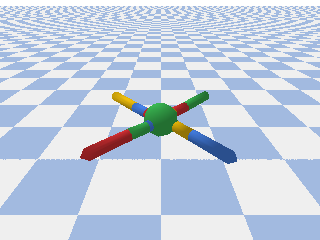

In [ ]:
from IPython.display import Image
from numpngw import write_apng

#imageio.mimsave('a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
write_apng('ant.png', images, delay=20)
Image(filename='ant.png')

In [57]:
import imageio

imageio.mimsave('ant.gif', [np.array(img) for i, img in enumerate(images) if i % 2 == 0], fps=29)

#### Walker

In [ ]:
from IPython.display import Image
from numpngw import write_apng

#imageio.mimsave('a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
write_apng('walker.png', images, delay=20)
Image(filename='walker.png')

In [ ]:
import imageio

imageio.mimsave('walker.gif', [np.array(img) for i, img in enumerate(images) if i % 2 == 0], fps=29)

### Plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

max_time_steps = 1e5
eval_freq = 5e3

steps = np.linspace(0, int(max_time_steps), int(max_time_steps//eval_freq)+1)

x = np.arange(len(steps))
sns.set()

In [ ]:
rewards = np.load("/content/results/rewards_Hyperfan_Walker2DBulletEnv-v0_seed5.npy")
std_deviations = np.load("/content/results/std_devs_Hyperfan_Walker2DBulletEnv-v0_seed5.npy")

In [ ]:
plt.plot(x, rewards, 'b-', label='mean_1')
plt.fill_between(x, rewards - std_deviations, rewards + std_deviations, color='b', alpha=0.2)
plt.show()